# Resolved Stellar Populations with RST

In this notebook we will walk through the formalism laid out in the associated paper (put link here) for calculating the expected number of stars resolved in a given observation with the future Nancy Grace Roman Space Telescope (RST). This code is intended to make it easier for those who would like to apply this formalism for use in predictions for the uses of RST. Our hope is that this formalism can be especially helpful in planning for future guest observing programs with RST.

The plots made in this notebook rely on the pre-calculation of a few quantites that depend on the stellar population that is being considered for observation. The code for the calculation of these quantities is provided with this repository, but it is a little slow, as we have only implemented it in Cython. For that reason, we also provide these values pre-calculated for a set of isochrones from the Module for Experiments in Stellar Astrophysics (MESA) Isochrones and Stellar Tracks (MIST) code (looked at in the separate walkthrough notebook) as well as for the Padova Isochrones, which we inspect here.

These precalculated quantities and the associated code used to calculate them are
1. $f_{\rm det}(B, \tau, Z,M_{\rm lim})$ The number fraction of a population's stars that are observed, which is a function of the band, $B$, the population parameters (just age $\tau$ and metallicity $Z$ in our case), and the limiting magnitude that is reached in the observation $M_{\rm lim}$. This is calculated in the code "fdetect_calc.py" and the corresponding output file is "fdet.npy"
2. $\left\langle L_{B,\tau,Z}\right\rangle$ The average luminosity of a given stellar population in a given band. This is calculated in "mean_luminosity_calc.py" and the corresponding output file is "lum.npy"
3. $\left\langle L_{B,\tau,Z}^2\right\rangle_{L<L_{\rm lim}}$ the second moment of luminosities less than some limiting luminosity. This is used to calculate the crowding limit of an observation based on the reasoning given in Olsen et al. 2003. This quantity is calculated in "l2_calc.py" and the corresponding output file is "l2.npy" These values are (by default) calculated for the same range of limiting absolute magnitudes (equivalent to the limiting luminsoity) as for $f_{\rm det}$.

We will proceed in making plots of these quantities in the order given above and focus on making simple plots first followed by making plots more similar to those found in our paper.

In [1]:
# all we need is numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# These are just preferences for making plots
# If it's giving you some errors, feel free to comment this out
plt.rc('font', **{'size': 8, 'sans-serif': ['Helvetica'], 'family': 'sans-serif'})
plt.rc('legend',**{'fontsize':6})                                             
plt.rc("text.latex", preamble=[
    "\\usepackage[T1]{fontenc}\\usepackage{amsmath}"])
plt.rc("text", usetex=True)
plt.rc('ps', usedistiller='xpdf')
plt.rc('savefig', **{'dpi': 300})

## Setting Global Parameters

We begin by setting several default values for the range of filters, ages, metallicities, and limiting magnitudes that are covered by our calculations outlined above. If you have changed the default ranges in re-calculating any of the above values, you will have to reset these values.

In [3]:
# First setting the range of metallicities and ages that are covered, these are our default values
metlist = np.array([0.5,0.25,0.0,-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0,-2.25,-2.5,-2.75,-3.,-3.25])
agelist = np.array([8.95,9.,9.05,9.1,9.15,9.2,9.25,9.3,9.35,9.4,9.45,9.5,9.55,9.6,9.65,9.7,9.75,9.8,9.85,9.9,9.95,10.,10.05,10.1])
nmet  = len(metlist)
nage  = len(agelist)

Then we set the parameters of the filters that we are looking at. Again, our default is the eight bands $F062$, $F087$, $F106$, $F129$, $F146$, $F158$, $F184$, and $K_s$.

In [4]:
nfilt = 8
filter_names = np.array([r"$F062$",r"$F087$",r"$F106$",r"$F129$",r"$F146$",r"$F158$",r"$F184$",r"$K_s$"])

And here we will set the exposure time that we would like to consider for our calculations below.

In [5]:
# We Define here the specific exposure time that we want to consider (in seconds)
texp = 1e3

We need a reference limiting magnitude for a reference exposure time in order to turn the limiting magnitude in to a distance (for a given exposure time) via Eq. 2 We use a reference exposure time of $10^3$ seconds and calculate the 5$\sigma$ point source detection limiting magnitude at that exposure time using Chris Hirata's code...
This is where these numbers come from

In [6]:
# Order here is R062, Z087, Y106, J129, W149, H158, F184, K_s/F213
ps_detect_5slim = np.array([27.8, 27.5, 27.4, 27.3, 27.6, 27.3, 26.8, 25.46])
# The pre-calculated values are calculated in the AB magnitude system, so if you 
# are thinking in terms of Vega-system surface brightnesses you'll have to 
# apply the conversions here. This is especially important for the redder bands
AB_Vega = np.array([0.147,0.485,0.647,0.950,1.012,1.281,1.546,1.819]) # This is m_AB - m_Vega

## Loading the Pre-Calculated Files

By default the range of limiting magnitudes that are covered are stored (somewhat inefficiently) in the "fdet.npy" file that has been previously calculated. So we will set this magnitude range by simply getting the magnitudes from this file.

To that end, we want to start loading up the pre-calculated data and making sure they have the right shape based on the parameters set above.

In [7]:
# Here is the f_det file
fdet = np.load("data/fdet_padova.npy")
# The average luminosity file
lum = np.load("data/lum_padova.npy")
# And the Second luminosity moment file
L2 = np.load("data/l2_padova.npy")

Okay, we've loaded them, now we want to assure that they have the right shapes. The shape of $f_{\rm det}$ should be (nmet, nage, nmags, nfilt + 1) where nmags is the number of limiting magnitudes that we calculated for, which we will allow to be determined by the shape of fdet itself, and then check for consistency.

In [8]:
# the limiting magnitudes that fdet was calculated for should take up 
# the "first" slot in the filter dimension. It's the same for every population
# and filter, so there's a lot of repeated information
nmags = fdet.shape[2]
Mags = fdet[0,0,:,0]

In [9]:
# check that fdet is the correct shape
print("These should be the same: (%d, %d, %d, %d)"%(nmet,nage,nmags,nfilt+1),fdet.shape)

These should be the same: (16, 24, 100, 9) (16, 24, 100, 9)


In [10]:
# The shape of lum should be (nmet, nage, nfilt)
print("These should be the same: (%d, %d, %d)"%(nmet,nage,nfilt),lum.shape)

These should be the same: (16, 24, 8) (16, 24, 8)


In [11]:
# The shape of L2 should be (nmet, nage, nfilt, nmags)
print("These should be the same: (%d, %d, %d, %d)"%(nmet,nage,nfilt,nmags),L2.shape)

These should be the same: (16, 24, 8, 100) (16, 24, 8, 100)


# Plotting the Fraction of a Population that is Detected

We want to begin by making plots which are similar to Figure 2 in the paper, showing how the fraction of the detected population evolves with the distance of the observed object and exposure time. Do do this we must first decide what distance range we want to consider and perform the correspondence between these distances and the limiting magnitudes that we have calculated $f_{\rm det}$ for using Eq. 2 in the paper. We will have to do this separately for each band pass.

In [12]:
# first calculate the distance modulus
# Order here is R062, Z087, Y106, J129, W149, H158, F184, K_s/F213
mu_R062 = ps_detect_5slim[0] - Mags + 1.25*np.log10(texp/1e3)
mu_Z087 = ps_detect_5slim[1] - Mags + 1.25*np.log10(texp/1e3)
mu_Y106 = ps_detect_5slim[2] - Mags + 1.25*np.log10(texp/1e3)
mu_J129 = ps_detect_5slim[3] - Mags + 1.25*np.log10(texp/1e3)
mu_W149 = ps_detect_5slim[4] - Mags + 1.25*np.log10(texp/1e3)
mu_H158 = ps_detect_5slim[5] - Mags + 1.25*np.log10(texp/1e3)
mu_F184 = ps_detect_5slim[6] - Mags + 1.25*np.log10(texp/1e3)
mu_F213 = ps_detect_5slim[7] - Mags + 1.25*np.log10(texp/1e3)

# then the distance in Mpc
d_R062 = 10**((mu_R062-25)/5)
d_Z087 = 10**((mu_Z087-25)/5)
d_Y106 = 10**((mu_Y106-25)/5)
d_J129 = 10**((mu_J129-25)/5)
d_W149 = 10**((mu_W149-25)/5)
d_H158 = 10**((mu_H158-25)/5)
d_F184 = 10**((mu_F184-25)/5)
d_F213 = 10**((mu_F213-25)/5)

# collect distances in to a single object
ds = np.array([d_R062,d_Z087,d_Y106,d_J129,d_W149,d_H158,d_F184,d_F213])

We'll start by making a plot for a single population: one metallicity and one age, but for each filter.

In [13]:
## now we specify the age and metallicity that we would like to consider
meti = 5
agej = 23

print("We are considering a population of [Fe/H] = %1.2f and Age = %1.2f Gyrs"%(metlist[meti],10**(agelist[agej]-9)))

We are considering a population of [Fe/H] = -0.75 and Age = 12.59 Gyrs


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


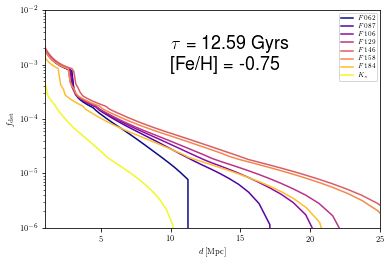

In [14]:
# plot f_det as a function of distance for each filter
for filtk in range(nfilt):
    plt.plot(ds[filtk],fdet[meti,agej,:,filtk+1],c=plt.cm.plasma((1.*filtk)/(nfilt-1)),label=filter_names[filtk])

# Some limits and labeling of the axes
plt.ylim(1e-6,1e-2)
plt.xlim(1,25)
plt.yscale("log")
plt.ylabel(r"$f_{\rm det}$")
plt.xlabel(r"$d \, [{\rm Mpc}]$")
# put in a legend
plt.legend()
# Putting in the labels for what population we're considering
plt.text(10,8e-4,r"[Fe/H] = %1.2f"%(metlist[meti]),fontsize=18)
plt.text(10,2e-3,r"$\tau$ = %1.2f Gyrs"%(10**(agelist[agej]-9)),fontsize=18)
plt.show()

We can see from the above that, generally, the $F146/W$ and $F158/H$ bands 'see' the furthest of any of the filters, which is why we use these the most for the creation of the plots in our paper.

Next we'll make a multi-panel plot showing the evolution of f_det for a bunch of different populations but only for a single filter. This is similar to Figure 2 in our paper

In [15]:
# start by specifying the filter
filtk = 5 # this is H

# This is for giving a reference for f_det, the N_6 parameter defined in Eq.4 of the paper
Norm = 1e6/1.3804085689210084
yticks = np.array([1e1,1e2,1e3,1e4])/Norm

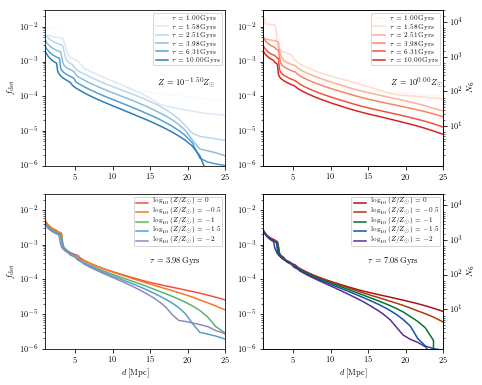

In [16]:
# Set the parameters to determine what we will plot here
ages_toplot = [1,5,9,13,17,21]
natp = len(ages_toplot)
meti1 = 8
meti2 = 2
agej1 = 13
agej2 = 18

## Subplots are separated by these comment bars
############################################################
ax1 = plt.subplot(221)
# loop over age, plotting for a sinlge metallicity specificed by meti1
for (ai,agej) in enumerate(ages_toplot):
    ax1.plot(ds[filtk],fdet[meti1,agej,:,filtk+1],c=plt.cm.Blues((1.*ai)/(natp+1)),label=r"$\tau = %1.2f \, {\rm Gyrs}$"%(10**(agelist[agej]-9)))

# some labeling
ax1.text(16,0.0002,r"$Z = 10^{%1.2f}Z_{\odot}$"%(metlist[meti1]))
ax1.set_ylabel(r"$f_{\rm det}$")
ax1.set_xlim(1,25.)
ax1.set_ylim(1e-6,3e-2)
ax1.set_yscale("log")
ax1.legend()

############################################################
ax2 = plt.subplot(222)
# loop over age, plotting for a sinlge metallicity specificed by meti2
for (ai,agej) in enumerate(ages_toplot):
    ax2.plot(ds[filtk],fdet[meti2,agej,:,filtk+1],c=plt.cm.Reds((1.*ai)/(natp+1)),label=r"$\tau = %1.2f \, {\rm Gyrs}$"%(10**(agelist[agej]-9)))

# some labeling
ax2.text(18,0.0002,r"$Z = 10^{%1.2f}Z_{\odot}$"%(metlist[meti2]))
ax2.set_xlim(1,25.)
ax2.set_ylim(1e-6,3e-2)
ax2.set_yscale("log")
ax2.legend()

# create a twin axis to show N_6 on the right hand side of the plot
ax2c = ax2.twinx()
ax2c.set_yscale("log")
ax2c.set_ylim(ax2.get_ylim())
ax2c.set_yticks(yticks)
ax2c.set_yticklabels(["$10^{%d}$"%np.log10(y*Norm) for y in yticks])
ax2c.set_ylabel(r"$N_6$")

############################################################
# the lower panel subplots are more hard-coded
ax3 = plt.subplot(223)
# plot different metallicities at a fixed age determined by agej1
ax3.plot(ds[filtk],fdet[2,agej1,:,filtk+1],c=plt.cm.Reds(4./7),label=r"$\log_{10}(Z/Z_{\odot})=0$")
ax3.plot(ds[filtk],fdet[4,agej1,:,filtk+1],c=plt.cm.Oranges(4./7),label=r"$\log_{10}(Z/Z_{\odot})=-0.5$")
ax3.plot(ds[filtk],fdet[6,agej1,:,filtk+1],c=plt.cm.Greens(4./7),label=r"$\log_{10}(Z/Z_{\odot})=-1$")
ax3.plot(ds[filtk],fdet[8,agej1,:,filtk+1],c=plt.cm.Blues(4./7),label=r"$\log_{10}(Z/Z_{\odot})=-1.5$")
ax3.plot(ds[filtk],fdet[10,agej1,:,filtk+1],c=plt.cm.Purples(4./7),label=r"$\log_{10}(Z/Z_{\odot})=-2$")

# some labeling
ax3.text(15,0.0003,r"$\tau = %1.2f\, {\rm Gyrs}$"%(10**(agelist[agej1]-9)))
ax3.set_xlabel(r"$d\, [{\rm Mpc}]$")
ax3.set_ylabel(r"$f_{\rm det}$")
ax3.set_xlim(1,25.)
ax3.set_ylim(1e-6,3e-2)
ax3.set_yscale("log")
ax3.legend()

############################################################
ax4 = plt.subplot(224)
ax4.plot(ds[filtk],fdet[2,agej2,:,filtk+1],c=plt.cm.Reds(6./7),label=r"$\log_{10}(Z/Z_{\odot})=0$")
ax4.plot(ds[filtk],fdet[4,agej2,:,filtk+1],c=plt.cm.Oranges(6./7),label=r"$\log_{10}(Z/Z_{\odot})=-0.5$")
ax4.plot(ds[filtk],fdet[6,agej2,:,filtk+1],c=plt.cm.Greens(6./7),label=r"$\log_{10}(Z/Z_{\odot})=-1$")
ax4.plot(ds[filtk],fdet[8,agej2,:,filtk+1],c=plt.cm.Blues(6./7),label=r"$\log_{10}(Z/Z_{\odot})=-1.5$")
ax4.plot(ds[filtk],fdet[10,agej2,:,filtk+1],c=plt.cm.Purples(6./7),label=r"$\log_{10}(Z/Z_{\odot})=-2$")

ax4.text(15,0.0003,r"$\tau = %1.2f\, {\rm Gyrs}$"%(10**(agelist[agej2]-9)))
ax4.set_xlabel(r"$d\, [{\rm Mpc}]$")
ax4.set_xlim(1,25.)
ax4.set_ylim(1e-6,3e-2)
ax4.set_yscale("log")
ax4.legend()

ax4c = ax4.twinx()
ax4c.set_yscale("log")
ax4c.set_ylim(ax4.get_ylim())
ax4c.set_yticks(yticks)
ax4c.set_yticklabels(["$10^{%d}$"%np.log10(y*Norm) for y in yticks])
ax4c.set_ylabel(r"$N_6$")

plt.gcf().set_size_inches((2.*3.37, 2*3.37*.8))
plt.tight_layout()
plt.show()

It is clear from the plot above that there are certain points in distance where $f_{\rm det}$ decreases drastically. As indicated in Figure 2 of the paper, these transitions correspond to certain stellar evolutionary stages. For example, the last major drop is indicated by the Tip of the Red Giant Branch (TRGB). Locating these evolutionary stages will depend on the particular stellar evolutionary code that was used for calculating the various pre-calculated parameters that we loaded above. In the MIST package we use their Equivalent Evolutionary Phases (EEPs) to define certain parts of the stellar evolutionary sequence, we then identify the brightest members of this population and use this along with the exposure time to determine the distance past which this population can no longer be seen. An example of how we do this for the $H$ band is given in the function below.

In [17]:
def get_dH(a,met,texp,path_to_isos):
    # arguments ar age "a" in log_10(age/years) so 9.0 == billion year old pop
    # metalliccity as "met" in log_10 with reference 0 at solar
    # exposure time as "texp" in seconds
    # and a string specifying the path to where the isochrones are stored "path_to_isos" 

    # we start by loading the specified MIST isochrone based on metallicity
    if met>-0.1:
        (eep,age,imass,T,L) = np.loadtxt("%s/mist_fehp%1.2f.iso.cmd"%(path_to_isos,abs(met)),usecols=[0,1,2,4,6]).T
        (H) = np.loadtxt("%s/mist_fehp%1.2f.iso.cmd"%(path_to_isos,abs(met)),usecols=[14]).T
    else:
        (eep,age,imass,T,L) = np.loadtxt("%s/mist_fehm%1.2f.iso.cmd"%(path_to_isos,abs(met)),usecols=[0,1,2,4,6]).T
        (H) = np.loadtxt("%s/mist_fehm%1.2f.iso.cmd"%(path_to_isos,abs(met)),usecols=[14]).T

    # We then restrict to the age under consideration
    sids = np.intersect1d(np.where(age>a-0.01),np.where(age<a+0.01))
    # This selects the Main sequence EEP <= 495, the brightest part of this will be the MSTO
    ids_ms = np.intersect1d(sids,np.where(eep<=495))
    # This selects the TRGB 560 <= EEP <= 580
    ids_trgb = np.intersect1d(sids,np.where(np.logical_and(eep<=580,eep>=560)))
    # This selects the Horizontal Branch/Red Clump 630 <= EEP <= 640
    ids_hb = np.intersect1d(sids,np.where(np.logical_and(eep>=630,eep<=640)))
    # This defines the faintest magnitude observable in the H band for the given texp
    mH_5slin = 25.819 + 1.25*np.log10(texp/1e3)
    # We then translate the brightest magnitude in each selection to a distance
    # using the faintest observable magnitude mH_slin
    d_trgb = 1e-5*10**((mH_5slin - min(H[ids_trgb]))/5.)
    d_hb = 1e-5*10**((mH_5slin - min(H[ids_hb]))/5.)
    d_ms = 1e-5*10**((mH_5slin - min(H[ids_ms]))/5.)
    return (d_trgb,d_hb,d_ms)

# The Stellar Density for a given Population

Here we will describe how to make plots similar to Figure 4 of our paper, which shows the total number density of stars (both observed and unobserved) for a given population. The only parameters required for making this plot are the surface brightness of the population being considered (Sigma) and the average luminosity of a star in this population $\left\langle L_{B,\tau, Z}\right\rangle$

We then determine the range of distances we want to look at

In [56]:
# set the distance range that you want to look over
(minD,maxD) = (1.,25.)
nDs = 200
drange = np.linspace(minD,maxD,nDs)
# then give distancce modulus
mus = 5*np.log10(drange*1e5)

We are then ready to make some plots showing the total stellar density of a population given it's surface brightness and distance. We'll start by making a plot for a single stellar population, one age, one metallicity, and at a given  surface brightness.

In [57]:
meti = 5
agej = 10
Sigma = 32 # in mag/arcsec^2

print("We are considering a population of [Fe/H] = %1.2f, Age = %1.2f Gyrs, and  Sigma = %d mag/arcsec^2"%(metlist[meti],10**(agelist[agej]-9),Sigma))

We are considering a population of [Fe/H] = -0.75, Age = 2.82 Gyrs, and  Sigma = 32 mag/arcsec^2


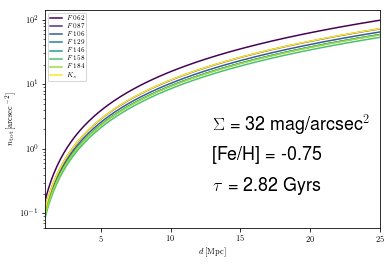

In [58]:
# plot n_tot as a function of distance for each filter
for filtk in range(nfilt):
    ntot = 10**((Sigma-mus)/-2.5)/lum[meti,agej,filtk]
    plt.plot(drange,ntot,c=plt.cm.viridis((1.*filtk)/(nfilt-1)),label=filter_names[filtk])
idmid = nDs//2
nref = ntot[idmid]

# Some limits and labeling of the axes
plt.xlim(1,25)
plt.yscale("log")
plt.ylabel(r"$n_{\rm tot}\, [{\rm arcsec}^{-2}]$")
plt.xlabel(r"$d \, [{\rm Mpc}]$")
# put in a legend
plt.legend()
# Putting in the labels for what population we're considering
plt.text(drange[idmid],nref/10,r"$\Sigma$ = %1.0f mag/arcsec$^2$"%(Sigma),fontsize=18)
plt.text(drange[idmid],nref/30,r"[Fe/H] = %1.2f"%(metlist[meti]),fontsize=18)
plt.text(drange[idmid],nref/90,r"$\tau$ = %1.2f Gyrs"%(10**(agelist[agej]-9)),fontsize=18)
plt.show()

Next we'll make a multi-panel plot that shows this quantity for a range of populations (metallicities, ages, and surface brightnesses). We'll start by specificing the different values we want to plot.

In [59]:
# metal indices to plot
met_toplot = [2,6,10]
nmtp = len(met_toplot)
# Surface brightness values to plot
Sig_toplot = [20,24,28,32]
# Ages to plot, we'll just do two
agej1 = 22
agej2 = 13

We then plot the results for each of the above for each of 4 filters (Y, J, H, and K). We'll vary the color of the plotted line for varying metallicity and the style of line for the two different ages. We won't change anything for the different surface brightnesses as they should be far enough apart to tell the difference anyway.  This should be similar to Figure 4 of the paper.

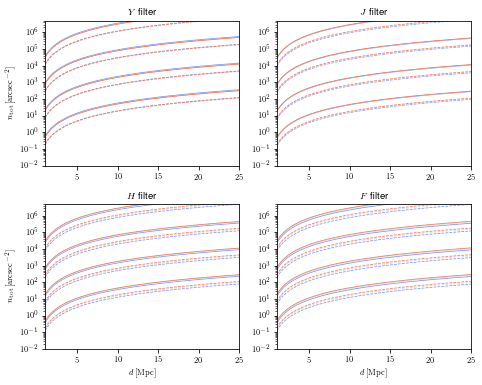

In [60]:
ax1 = plt.subplot(221)
filtj = 1
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax1.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj],c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax1.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj],'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax1.set_title(r"$Y$ filter")
ax1.set_yscale("log")
ax1.set_ylim(1e-2,5e6)
ax1.set_xlim(1,25)
ax1.set_ylabel(r"$n_{\rm tot} \, [{\rm arcsec}^{-2}]$")

ax2 = plt.subplot(222)
filtj = 2
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax2.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj],c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax2.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj],'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax2.set_title(r"$J$ filter")
ax2.set_yscale("log")
ax2.set_ylim(1e-2,5e6)
ax2.set_xlim(1,25)


ax3 = plt.subplot(223)
filtj = 3
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax3.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj],c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax3.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj],'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax3.set_title(r"$H$ filter")
ax3.set_yscale("log")
ax3.set_ylim(1e-2,5e6)
ax3.set_xlim(1,25)
ax3.set_ylabel(r"$n_{\rm tot} \, [{\rm arcsec}^{-2}]$")
ax3.set_xlabel(r"$d \, [{\rm Mpc}]$")

ax4 = plt.subplot(224)
filtj = 4
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax4.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj],c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ax4.plot(drange,10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj],'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax4.set_title(r"$F$ filter")
ax4.set_yscale("log")
ax4.set_ylim(1e-2,5e6)
ax4.set_xlim(1,25)
ax4.set_xlabel(r"$d \, [{\rm Mpc}]$")

plt.gcf().set_size_inches((2.*3.37, 2*3.37*.8))
plt.tight_layout()
plt.show()

# The Stellar Density of Detected Stars

Finally, we want to get to the total number density of detected stars, which is a combination of the quantities from the past two sections. Again, we'll start with a plot for a single population and then give an example more similar to our Figure 5.

In [61]:
# Again, we specify the details of the population under consideration
meti = 5
agej = 10
Sigma = 32 # in mag/arcsec^2

print("We are considering a population of [Fe/H] = %1.2f, Age = %1.2f Gyrs, and  Sigma = %d mag/arcsec^2"%(metlist[meti],10**(agelist[agej]-9),Sigma))

We are considering a population of [Fe/H] = -0.75, Age = 2.82 Gyrs, and  Sigma = 32 mag/arcsec^2


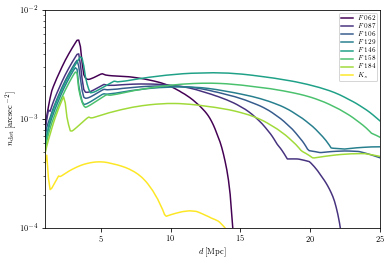

In [65]:
# plot n_det = n_tot*f_det as a function of distance for each filter
for filtk in range(nfilt):
    ntot = 10**((Sigma-mus)/-2.5)/lum[meti,agej,filtk]
    fdet_here = np.interp(drange,ds[filtk],fdet[meti,agej,:,filtk+1])
    plt.plot(drange,ntot*fdet_here,c=plt.cm.viridis((1.*filtk)/(nfilt-1)),label=filter_names[filtk])
idmid = nDs//2
nref = ntot[idmid]*fdet_here[idmid]

# Some limits and labeling of the axes
plt.xlim(1,25)
plt.ylim(1e-4,1e-2)
plt.yscale("log")
plt.ylabel(r"$n_{\rm det}\, [{\rm arcsec}^{-2}]$")
plt.xlabel(r"$d \, [{\rm Mpc}]$")
# put in a legend
plt.legend()
# Putting in the labels for what population we're considering
#plt.text(drange[idmid],nref/10,r"$\Sigma$ = %1.0f mag/arcsec$^2$"%(Sigma),fontsize=18)
#plt.text(drange[idmid],nref/30,r"[Fe/H] = %1.2f"%(metlist[meti]),fontsize=18)
#plt.text(drange[idmid],nref/90,r"$\tau$ = %1.2f Gyrs"%(10**(agelist[agej]-9)),fontsize=18)
plt.show()

Interestingly we see that the number density of detected stars is a reasonably flat function of distance out to quite large distances! This is because the amount that $n_{\rm tot}$ is increasing (because fixed apparent magnitude per square arcsecond translates to higher absolute magnitude per square arcsecond at further distance) is nearly exactly compensated by the amount that $f_{\det}$ is decreasing (mainly due to the distribution of stars along the RGB). The degree to which this is true will depend on the particular IMF that is used.

In [66]:
# metal indices to plot
met_toplot = [2,6,10]
nmtp = len(met_toplot)
# Surface brightness values to plot
Sig_toplot = [20,24,28,32]
# Ages to plot, we'll just do two
agej1 = 22
agej2 = 13

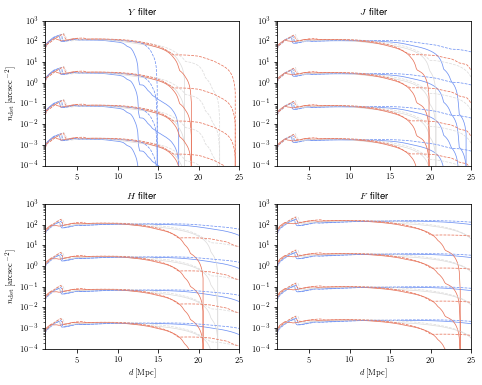

In [68]:
ax1 = plt.subplot(221)
filtj = 1
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej1,:,filtj+1])
        ax1.plot(drange,ntot_tp*fdet_tp,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej2,:,filtj+1])
        ax1.plot(drange,ntot_tp*fdet_tp,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax1.set_title(r"$Y$ filter")
ax1.set_yscale("log")
ax1.set_ylim(1e-4,1e3)
ax1.set_xlim(1,25)
ax1.set_ylabel(r"$n_{\rm det} \, [{\rm arcsec}^{-2}]$")

ax2 = plt.subplot(222)
filtj = 2
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej1,:,filtj+1])
        ax2.plot(drange,ntot_tp*fdet_tp,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej2,:,filtj+1])
        ax2.plot(drange,ntot_tp*fdet_tp,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax2.set_title(r"$J$ filter")
ax2.set_yscale("log")
ax2.set_ylim(1e-4,1e3)
ax2.set_xlim(1,25)


ax3 = plt.subplot(223)
filtj = 3
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej1,:,filtj+1])
        ax3.plot(drange,ntot_tp*fdet_tp,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej2,:,filtj+1])
        ax3.plot(drange,ntot_tp*fdet_tp,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax3.set_title(r"$H$ filter")
ax3.set_yscale("log")
ax3.set_ylim(1e-4,1e3)
ax3.set_xlim(1,25)
ax3.set_ylabel(r"$n_{\rm det} \, [{\rm arcsec}^{-2}]$")
ax3.set_xlabel(r"$d \, [{\rm Mpc}]$")

ax4 = plt.subplot(224)
filtj = 4
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej1,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej1,:,filtj+1])
        ax4.plot(drange,ntot_tp*fdet_tp,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    for Sig in Sig_toplot:
        ntot_tp = 10**((Sig-mus)/-2.5)/lum[meti,agej2,filtj]
        fdet_tp = np.interp(drange,ds[filtj],fdet[meti,agej2,:,filtj+1])
        ax4.plot(drange,ntot_tp*fdet_tp,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax4.set_title(r"$F$ filter")
ax4.set_yscale("log")
ax4.set_ylim(1e-4,1e3)
ax4.set_xlim(1,25)
ax4.set_xlabel(r"$d \, [{\rm Mpc}]$")

plt.gcf().set_size_inches((2.*3.37, 2*3.37*.8))
plt.tight_layout()
plt.show()

# Crowding Limits

Finally, we want to show how to calculate the crowding limit of an observation, this involves the final quantity that we have pre-calculated: $\left\langle L_{B,\tau, Z}^2\right\rangle_{L<L_{\rm lim}}$. As with the other plots we will begin by making a simple, single age and metallicity stellar population at a fixed surface brightness.

In [69]:
# Again, we specify the details of the population under consideration
meti = 5
agej = 15
Sigma = 32 # in mag/arcsec^2

print("We are considering a population of [Fe/H] = %1.2f, Age = %1.2f Gyrs, and  Sigma = %d mag/arcsec^2"%(metlist[meti],10**(agelist[agej]-9),Sigma))

We are considering a population of [Fe/H] = -0.75, Age = 5.01 Gyrs, and  Sigma = 32 mag/arcsec^2


The next function will help us by interpolating in order to evaluate the last term in Equation 8 of our paper.

In [70]:
def get_olsen_term(sigmaB,A,Bcut,Lavg,l2_Mags,l2):
    # interpolate the l2 values calculated for a range of limiting 
    # absolute magnitudes on to the limiting absolute magnitudes
    # calculated here
    L2_interp = np.interp(Bcut[::-1],l2_Mags[::-1],l2[::-1])[::-1]
    # calculate the last term in Equation 8 in our paper
    return 2.5*np.log10(((sigmaB/1.086)**2)*(Lavg)/(A*L2_interp))

These next parameters are from the Olsen '03 paper and we assume some simple values,

In [71]:
sigm = 0.1 # photometric precision of measurement in magnitudes
ares = (0.1)**2 # psf area in square arceseconds (assumed top hat)

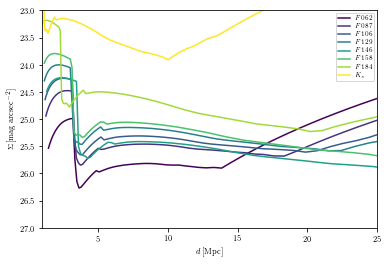

In [73]:
# plot the surface brightness brighter than which we cannot accurately
# measure the magnitudes of the stars that we should be able to detect
for filtk in range(nfilt):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej,filtk],Mags,L2[meti,agej,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    
    plt.plot(ds[filtk],lso,c=plt.cm.viridis((1.*filtk)/(nfilt-1)),label=filter_names[filtk])

# Some limits and labeling of the axes
plt.xlim(1,25)
plt.ylim(27,23)
plt.ylabel(r"$\Sigma \, [{\rm mag}\, {\rm arcsec}^{-2}]$")
plt.xlabel(r"$d \, [{\rm Mpc}]$")
# put in a legend
plt.legend()
plt.show()

Now, again we will make a multi-panel plot to try to illustrate some of the emrgent trends in this quantity as a function of age and metallicity.

In [31]:
# metal indices to plot
met_toplot = [2,6,10]
nmtp = len(met_toplot)
# Ages to plot, we'll just do two
agej1 = 22
agej2 = 13

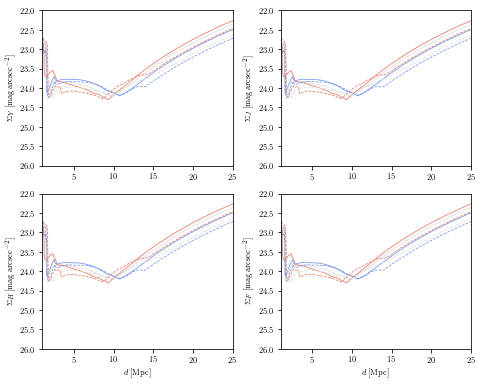

In [33]:
ax1 = plt.subplot(221)
filtk = 1
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej1,filtk],Mags,L2[meti,agej1,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej1,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax1.plot(ds[filtk],lso,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
        
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej2,filtk],Mags,L2[meti,agej2,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej2,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax1.plot(ds[filtk],lso,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax1.set_xlim(1,25)
ax1.set_ylim(26,22)
ax1.set_ylabel(r"$\Sigma_Y \, [{\rm mag}\, {\rm arcsec}^{-2}]$")

ax2 = plt.subplot(222)
filtj = 2
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej1,filtk],Mags,L2[meti,agej1,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej1,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax2.plot(ds[filtk],lso,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej2,filtk],Mags,L2[meti,agej2,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej2,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax2.plot(ds[filtk],lso,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax2.set_xlim(1,25)
ax2.set_ylim(26,22)
ax2.set_ylabel(r"$\Sigma_J \, [{\rm mag}\, {\rm arcsec}^{-2}]$")


ax3 = plt.subplot(223)
filtj = 3
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej1,filtk],Mags,L2[meti,agej1,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej1,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax3.plot(ds[filtk],lso,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej2,filtk],Mags,L2[meti,agej2,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej2,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax3.plot(ds[filtk],lso,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax3.set_xlim(1,25)
ax3.set_ylim(26,22)
ax3.set_ylabel(r"$\Sigma_H \, [{\rm mag}\, {\rm arcsec}^{-2}]$")
ax3.set_xlabel(r"$d \, [{\rm Mpc}]$")

ax4 = plt.subplot(224)
filtj = 4
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej1,filtk],Mags,L2[meti,agej1,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej1,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax4.plot(ds[filtk],lso,c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
for (mi,meti) in enumerate(met_toplot):
    mus = 5*np.log10(ds[filtk]*1e5)
    Mcut = ps_detect_5slim[filtk] - mus
    ols_fac = get_olsen_term(sigm,ares,Mcut,lum[meti,agej2,filtk],Mags,L2[meti,agej2,filtk])
    L2_interp = np.interp(Mcut[::-1],Mags[::-1],L2[meti,agej2,filtk][::-1])[::-1]
    lso =  2*Mcut + mus - ols_fac
    ax4.plot(ds[filtk],lso,'--',c=plt.cm.coolwarm((0.5+mi*1.)/nmtp),lw=0.75)
ax4.set_xlim(1,25)
ax4.set_ylim(26,22)
ax4.set_ylabel(r"$\Sigma_F \, [{\rm mag}\, {\rm arcsec}^{-2}]$")
ax4.set_xlabel(r"$d \, [{\rm Mpc}]$")

plt.gcf().set_size_inches((2.*3.37, 2*3.37*.8))
plt.tight_layout()
plt.show()

# $n_{\rm det}$ at $\Sigma_{\rm lim}$

Okay, one last thing. We now want to take a look at what the number density of detected stars would be if we observed at the limiting

Now you can try! We hope that this code can be used for making a bunch of predictions for observations with RST and hopefully help to plan some guest observing programs!

In [31]:
# Your code goes here!
